In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [2]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

# Train Problem

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/hhk998402/Time-Series-Forecasting-SARIMAX/refs/heads/master/Train.csv')

data.index = data.date_time
data = data.drop(['date_time'],axis=1)

data.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [4]:
data['is_holiday'].unique()

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [5]:
# Create 'holiday' column: 1 if holiday, otherwise 0
data['holiday'] = data['is_holiday'].notna().astype(int)

data.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume,holiday
date_time,,,,,,,,,,,,,,,
2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,0
2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516,0
2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,0
2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,0
2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33750 entries, 2012-10-02 09:00:00 to 2017-05-17 23:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_holiday           43 non-null     object 
 1   air_pollution_index  33750 non-null  int64  
 2   humidity             33750 non-null  int64  
 3   wind_speed           33750 non-null  int64  
 4   wind_direction       33750 non-null  int64  
 5   visibility_in_miles  33750 non-null  int64  
 6   dew_point            33750 non-null  int64  
 7   temperature          33750 non-null  float64
 8   rain_p_h             33750 non-null  float64
 9   snow_p_h             33750 non-null  float64
 10  clouds_all           33750 non-null  int64  
 11  weather_type         33750 non-null  object 
 12  weather_description  33750 non-null  object 
 13  traffic_volume       33750 non-null  int64  
 14  holiday              33750 non-null  int32  
dtypes: float6

##### We will work only with not holidays days.

In [7]:
# Filter the dataset to include only non-holiday entries
df = data[data['holiday'] == 0]

# Create new DataFrame with only some columns
df = df[['temperature', 'rain_p_h', 'snow_p_h', 'humidity', 'traffic_volume']]   

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 2012-10-02 09:00:00 to 2017-05-17 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temperature     33707 non-null  float64
 1   rain_p_h        33707 non-null  float64
 2   snow_p_h        33707 non-null  float64
 3   humidity        33707 non-null  int64  
 4   traffic_volume  33707 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 1.5+ MB


In [8]:
df.describe()

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume
count,33707.000000,33707.000000,33707.000000,33707.000000,33707.000000
mean,280.072111,0.449214,0.000318,71.209630,3243.182395
std,13.417186,53.560629,0.009766,16.853159,1990.883139
min,0.000000,0.000000,0.000000,13.000000,0.000000
25%,271.720000,0.000000,0.000000,60.000000,1173.000000
50%,280.150000,0.000000,0.000000,72.000000,3340.000000
75%,290.620000,0.000000,0.000000,85.000000,4928.000000
max,308.240000,9831.300000,0.510000,100.000000,7280.000000


In [9]:
df

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume
date_time,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,89,5545
2012-10-02 10:00:00,289.36,0.0,0.0,67,4516
2012-10-02 11:00:00,289.58,0.0,0.0,66,4767
2012-10-02 12:00:00,290.13,0.0,0.0,66,5026
2012-10-02 13:00:00,291.14,0.0,0.0,65,4918
...,...,...,...,...,...
2017-05-17 21:00:00,287.88,0.0,0.0,85,2348
2017-05-17 22:00:00,286.95,0.0,0.0,70,2194
2017-05-17 22:00:00,286.95,0.0,0.0,70,2194


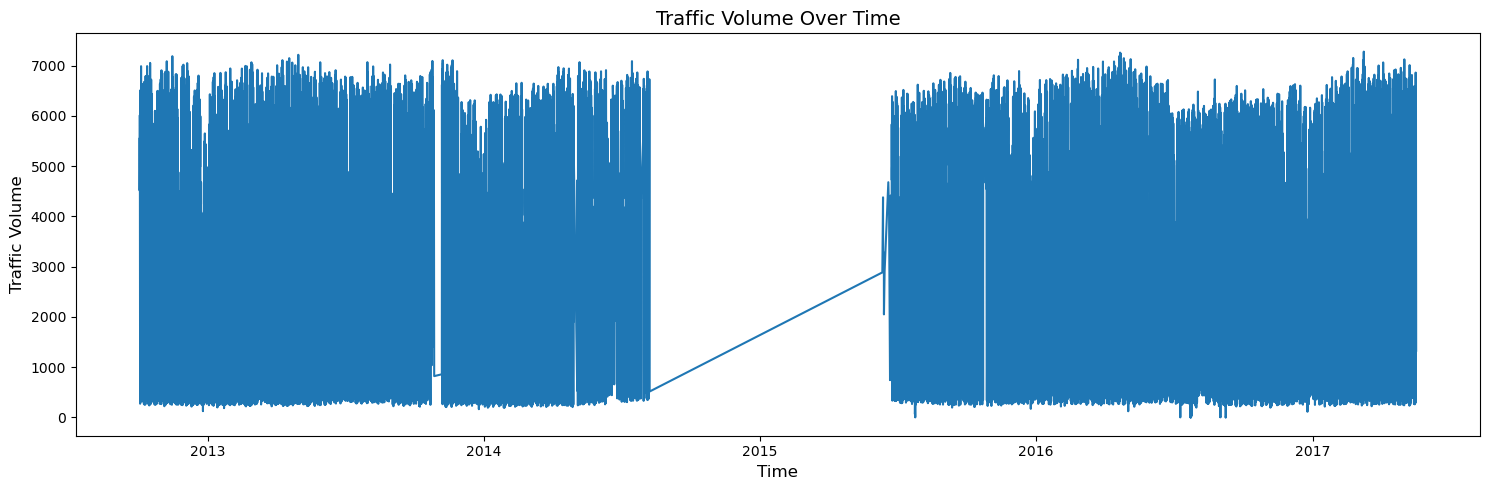

In [10]:
# Ensure index is in datetime format
df.index = pd.to_datetime(df.index)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Set figure size

# Plot traffic volume using line plot
ax.plot(df.index, df['traffic_volume'])  # Explicitly set datetime index for x-axis

# Formatting
ax.set_xlabel('Time', fontsize=12)  # Set x-axis label
ax.set_ylabel('Traffic Volume', fontsize=12)  # Set y-axis label
ax.set_title('Traffic Volume Over Time', fontsize=14)  # Set title

# Set x-limits using not datetime objects
#ax.set_xlim(0, 33707)

# Show the plot
plt.tight_layout()
plt.show();

In [11]:
# Selecionar apenas as linhas com ano de 2015
df_2014 = df[df.index.year == 2014]

# Visualizar o resultado
df_2014.tail(10)

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume
date_time,,,,,
2014-08-07 16:00:00,300.99,0.0,0.0,79,6731
2014-08-07 17:00:00,300.48,0.0,0.0,80,6278
2014-08-07 18:00:00,299.98,0.0,0.0,76,5121
2014-08-07 19:00:00,299.15,0.0,0.0,79,3826
2014-08-07 20:00:00,297.65,0.0,0.0,77,3441
2014-08-07 21:00:00,295.46,0.0,0.0,75,3274
2014-08-07 22:00:00,294.69,0.0,0.0,72,2479
2014-08-07 23:00:00,294.48,0.0,0.0,70,1491
2014-08-08 00:00:00,293.45,0.0,0.0,69,848


In [12]:
# Selecionar apenas as linhas com ano de 2015
df_2015 = df[df.index.year == 2015]

# Visualizar o resultado
df_2015.head(10)

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume
date_time,,,,,
2015-06-11 20:00:00,287.586,0.0,0.0,65,2886
2015-06-12 18:00:00,297.543,0.0,0.0,65,4380
2015-06-12 20:00:00,292.061,0.0,0.0,63,3095
2015-06-12 21:00:00,292.061,0.0,0.0,63,3299
2015-06-13 21:00:00,294.840,0.0,0.0,68,3040
2015-06-13 23:00:00,293.137,0.0,0.0,66,2051
2015-06-14 20:00:00,296.064,0.0,0.0,70,2909
2015-06-19 18:00:00,299.007,0.0,0.0,70,4681
2015-06-20 18:00:00,295.369,0.0,0.0,74,4045


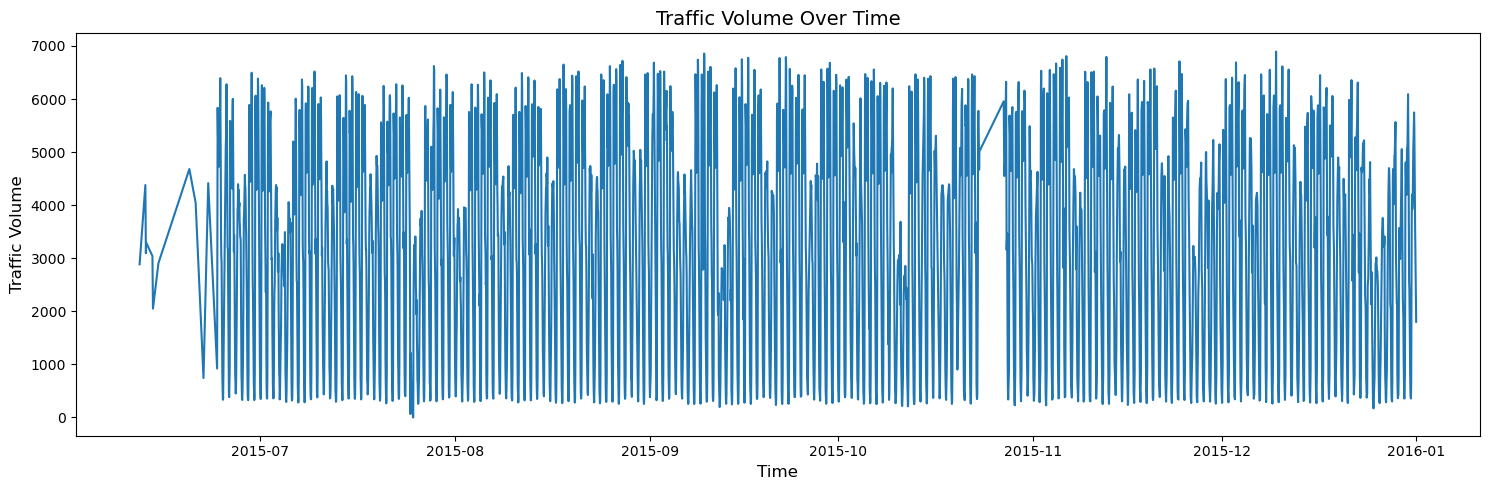

In [13]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Set figure size

# Plot traffic volume using line plot
ax.plot(df_2015.index, df_2015['traffic_volume'])  # Explicitly set datetime index for x-axis

# Formatting
ax.set_xlabel('Time', fontsize=12)  # Set x-axis label
ax.set_ylabel('Traffic Volume', fontsize=12)  # Set y-axis label
ax.set_title('Traffic Volume Over Time', fontsize=14)  # Set title

# Set x-limits using not datetime objects
#ax.set_xlim(0, 33707)

# Show the plot
plt.tight_layout()
plt.show();

In [14]:
# Define the start and end of the desired interval
start_date = pd.to_datetime("2015-07-01 06:00:00")
end_date = pd.to_datetime("2015-10-01 06:00:00")

# Filter the DataFrame based on the datetime index
new_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Remove rows with duplicate index values (keeping the first occurrence)
new_df = new_df[~new_df.index.duplicated(keep='first')]

# Show the result
new_df.head(30)

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume
date_time,,,,,
2015-07-01 06:00:00,287.38,0.0,0.0,41,5741
2015-07-01 07:00:00,287.58,0.0,0.0,50,6261
2015-07-01 09:00:00,288.58,0.0,0.0,56,4409
2015-07-01 10:00:00,289.24,0.0,0.0,68,4273
2015-07-01 11:00:00,289.44,0.0,0.0,77,4469
2015-07-01 12:00:00,290.53,0.0,0.0,88,4625
2015-07-01 13:00:00,292.17,0.0,0.0,82,4462
2015-07-01 14:00:00,293.61,0.0,0.0,93,4996
2015-07-01 15:00:00,294.85,0.0,0.0,93,5623


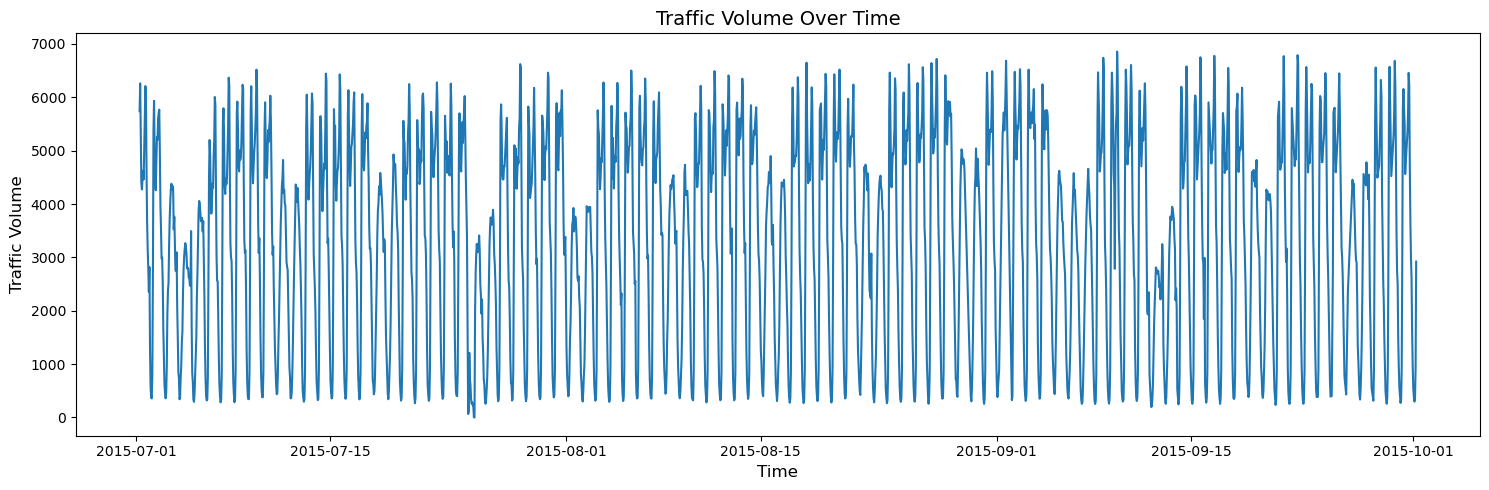

In [15]:
# Ensure index is in datetime format
new_df.index = pd.to_datetime(new_df.index)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Set figure size

# Plot traffic volume using line plot
ax.plot(new_df.index, new_df['traffic_volume'])  # Explicitly set datetime index for x-axis

# Formatting
ax.set_xlabel('Time', fontsize=12)  # Set x-axis label
ax.set_ylabel('Traffic Volume', fontsize=12)  # Set y-axis label
ax.set_title('Traffic Volume Over Time', fontsize=14)  # Set title

# Set x-limits using not datetime objects
#ax.set_xlim(0, 33707)

# Show the plot
plt.tight_layout()
plt.show();

In [16]:
#last = new_df.tail(1000)

In [17]:
train = new_df.iloc[:int(0.90*len(new_df))]
test = new_df.iloc[int(0.90*len(new_df)):]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (1907, 5)
Test shape: (212, 5)

                     temperature  rain_p_h  snow_p_h  humidity  traffic_volume
date_time                                                                     
2015-09-20 08:00:00       283.84       0.0       0.0        69            2147
2015-09-20 09:00:00       286.63       0.0       0.0        68            3364
2015-09-20 10:00:00       288.74       0.0       0.0        67            4270
2015-09-20 11:00:00       291.42       0.0       0.0        66            4219
2015-09-20 12:00:00       292.74       0.0       0.0        64            4239

                     temperature  rain_p_h  snow_p_h  humidity  traffic_volume
date_time                                                                     
2015-09-20 13:00:00       293.77      0.00       0.0        63            4124
2015-09-20 14:00:00       294.58      0.00       0.0        62            4070
2015-09-20 15:00:00       294.54      0.00       0.0        64            4185
2015-0

In [18]:
exog_data = train[['rain_p_h', 'snow_p_h', 'humidity', 'temperature']]  # Multiple column selection (rain, snow, humidity, temperature)
endog_data = train['traffic_volume']                                    # Target variable selection

In [19]:
endo_series = train['traffic_volume']

type(endo_series)

pandas.core.series.Series

### Finding d & D

In [20]:
from statsmodels.tsa.stattools import adfuller

def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(endog_data)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -5.0863, p-value = 0.0000

Non-seasonal differencing term (d): 0


In [21]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52, 365]:

    D = determine_seasonal_D(endog_data, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 1
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0
Seasonal differencing term (D) for 365: 2


### Testing Approachs

In [22]:
# Perform a full search over the same grid as the manual SARIMAX model
auto_model = pm.auto_arima(
    endo_series,                # The time series data
    seasonal=True,              # Enable seasonal component
    m=24,                       # Seasonal period
    d=0,                        # Set differencing 
    D=1,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p from 0 to 3
    start_q=0, max_q=3,         # q from 0 to 3
    start_P=0, max_P=2,         # P from 0 to 2
    start_Q=0, max_Q=2,         # Q from 0 to 2
    stepwise=True,              # Disable stepwise search (enable full grid search)
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=32227.121, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=29857.314, Time=14.15 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=30509.067, Time=27.78 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=32225.389, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=29934.770, Time=0.58 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=29744.240, Time=78.45 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=192.66 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=58.72 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=31963.704, Time=59.47 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=29425.866, Time=126.79 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=29500.110, Time=37.92 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=232.08 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=81.01 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=29418.173, Time=121.71 sec
 ARIMA(3,0,0)(

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape


def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(3))]*2            # Define search ranges for seasonal parameters (P, Q): each from 0 to 2
d = 0
D = 1
S = 24

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(endo_series,                   # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   # Particular case m = 30
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 144
Running model #0 using SARIMA(0,0,0)(0,1,0,24)
Running model #15 using SARIMA(0,0,1)(2,1,0,24)
Running model #30 using SARIMA(0,0,3)(1,1,0,24)
Running model #45 using SARIMA(1,0,1)(0,1,0,24)
Running model #60 using SARIMA(1,0,2)(2,1,0,24)
Running model #75 using SARIMA(2,0,0)(1,1,0,24)
Running model #90 using SARIMA(2,0,2)(0,1,0,24)
Running model #105 using SARIMA(2,0,3)(2,1,0,24)
Running model #120 using SARIMA(3,0,1)(1,1,0,24)
Running model #135 using SARIMA(3,0,3)(0,1,0,24)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,71,"(1, 0, 3)","(2, 1, 2)",28392.336001,28392.434847,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,68,"(1, 0, 3)","(1, 1, 2)",28398.386369,28398.465403,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,65,"(1, 0, 3)","(0, 1, 2)",28410.697668,28410.759105,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,98,"(2, 0, 2)","(2, 1, 2)",28410.828524,28410.927317,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,95,"(2, 0, 2)","(1, 1, 2)",28411.222648,28411.301639,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


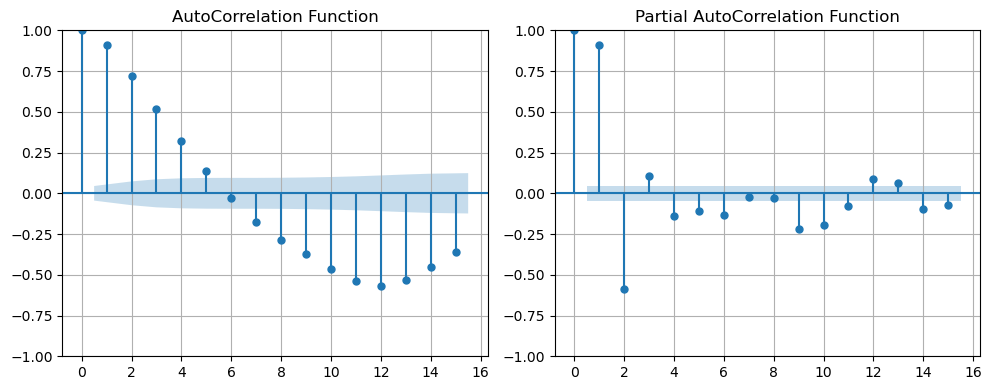

In [24]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(endo_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(endo_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show();

In [25]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_201 = SARIMAX(endo_series,                         # Time series data
                    order=(2, 0, 1),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 1, 0, 24),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_201 = model_201.fit()

# Display summary of the model
print(model_fit_201.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      traffic_volume   No. Observations:                 1907
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 24)   Log Likelihood              -14310.815
Date:                             Mon, 05 May 2025   AIC                          28633.630
Time:                                     15:11:39   BIC                          28666.712
Sample:                                          0   HQIC                         28645.830
                                            - 1907                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0546      0.033     31.496      0.000       0.989       1.120
ar.L2         -0.2822      

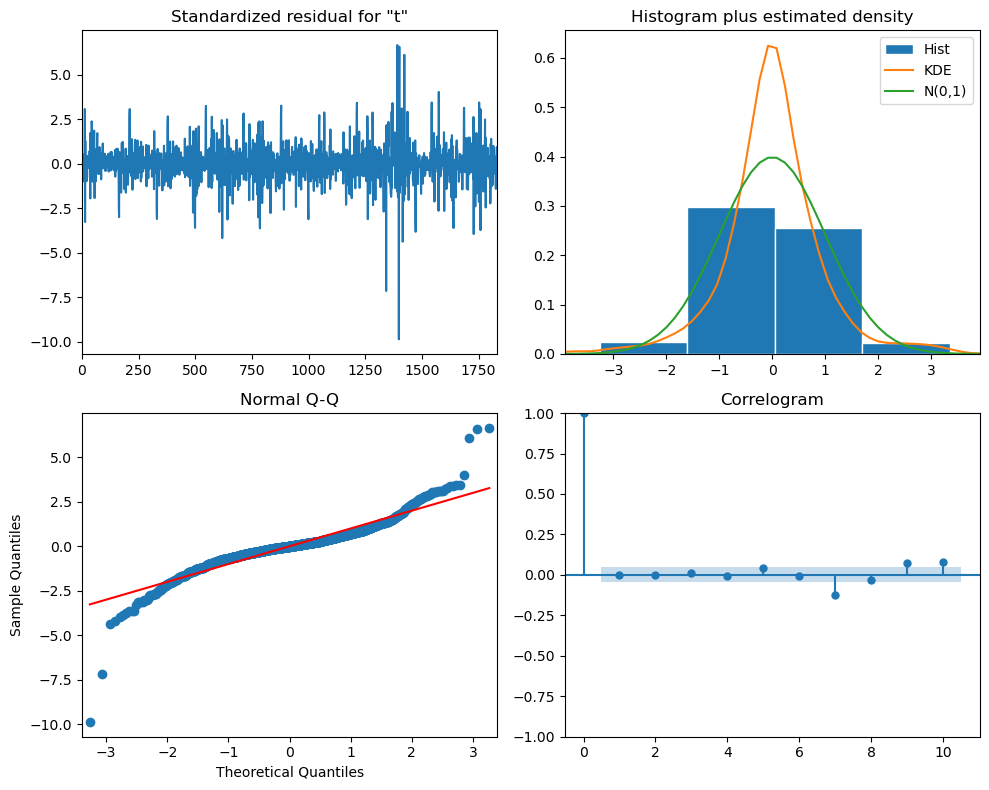

In [26]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_201.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox


# Extract the residuals (errors) from the fitted model
residuals = model_fit_201.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,6.509544,1.072970e-02
2,7.122176,2.840790e-02
3,13.465426,3.730948e-03
4,15.853266,3.222513e-03
5,25.817608,9.680530e-05
6,28.140546,8.840533e-05
7,33.589009,2.055836e-05
8,33.891116,4.251412e-05
9,53.584357,2.264291e-08
10,71.986219,1.830769e-11


In [28]:
from statsmodels.stats.stattools import durbin_watson


# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.8387
Conclusion: No significant autocorrelation.


In [29]:
# Forecast the next steps time points
forecast_201 = model_fit_201.get_forecast(steps=212)

# Extract predicted mean and confidence intervals
forecast_mean_201 = forecast_201.predicted_mean
conf_int_201 = forecast_201.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_201.values                               # Forecast mean

test['Error S'] = test['Forecast S'] - test['traffic_volume']

test['Lower 95% CI S'] = conf_int_201.iloc[:, 0].values                     # Lower bound
test['Upper 95% CI S'] = conf_int_201.iloc[:, 1].values                     # Upper bound

# Show the updated test DataFrame
test.head()

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
date_time,,,,,,,,,
2015-09-20 13:00:00,293.77,0.00,0.0,63,4124,4102.720515,-21.279485,2936.755049,5268.685981
2015-09-20 14:00:00,294.58,0.00,0.0,62,4070,4395.888942,325.888942,2540.886919,6250.890966
2015-09-20 15:00:00,294.54,0.00,0.0,64,4185,4568.961005,383.961005,2363.688202,6774.233808
2015-09-20 16:00:00,294.45,0.00,0.0,61,4183,5080.525390,897.525390,2716.904287,7444.146493
2015-09-20 17:00:00,292.86,0.25,0.0,62,4054,5141.018016,1087.018016,2711.845932,7570.190100


In [30]:
test.tail()

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
date_time,,,,,,,,,
2015-10-01 01:00:00,278.85,0.0,0.0,80,380,441.153802,61.153802,-4653.417482,5535.725086
2015-10-01 02:00:00,278.88,0.0,0.0,80,298,877.687583,579.687583,-4216.883710,5972.258876
2015-10-01 03:00:00,278.89,0.0,0.0,79,373,1659.591926,1286.591926,-3434.979369,6754.163221
2015-10-01 04:00:00,278.60,0.0,0.0,78,918,2165.878029,1247.878029,-2928.693266,7260.449325
2015-10-01 05:00:00,278.27,0.0,0.0,77,2922,2960.089566,38.089566,-2134.481729,8054.660862


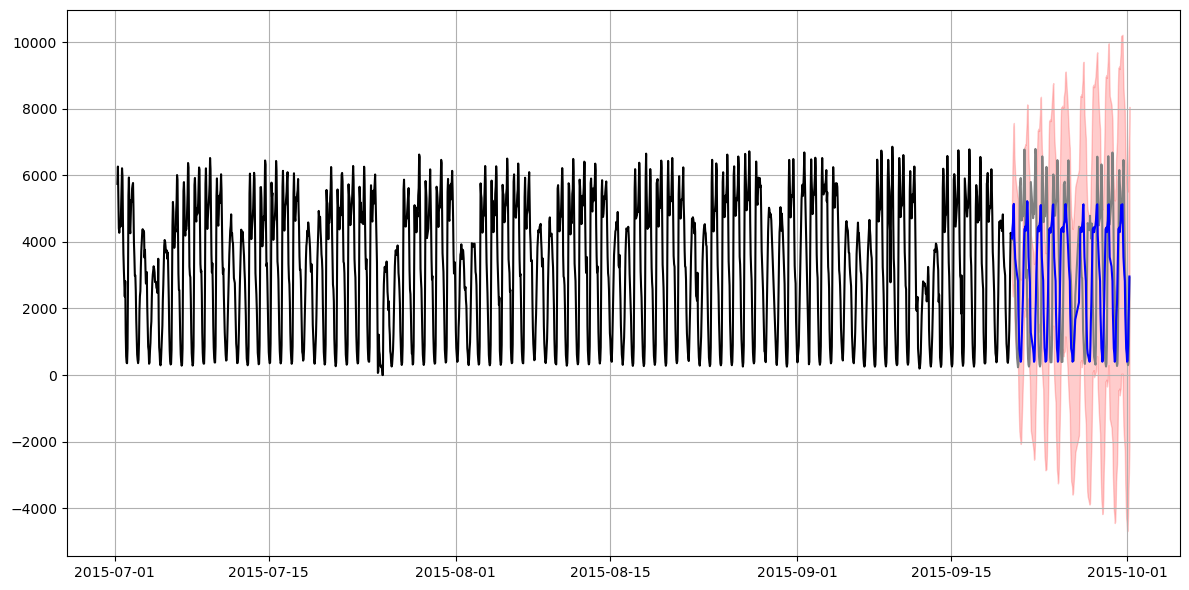

In [31]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_201.iloc[:, 0],     # Lower bound
                 conf_int_201.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['traffic_volume'], label='Train', color='black')                      
plt.plot(test.index, test['traffic_volume'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast S'], label='Forecasting', color='blue') 

# Formatting
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('Traffic Volume', fontsize=12)  
ax.set_title('Traffic Volume Over Time', fontsize=14)  
plt.grid(True) 
#plt.ylim(0,8000)

# Show the plot
plt.tight_layout()
plt.show();

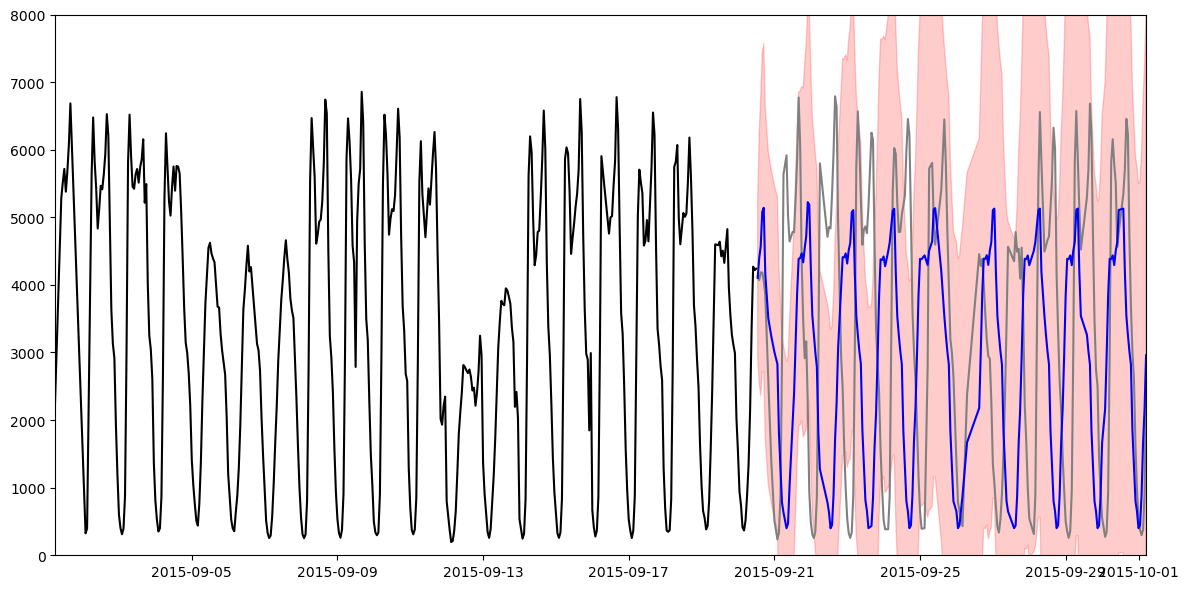

In [32]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_201.iloc[:, 0],     # Lower bound
                 conf_int_201.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['traffic_volume'], label='Train', color='black')                      
plt.plot(test.index, test['traffic_volume'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast S'], label='Forecasting', color='blue') 

# Formatting
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('Traffic Volume', fontsize=12)  
ax.set_title('Traffic Volume Over Time', fontsize=14)  
plt.xlim(pd.to_datetime('2015-09-01 06:00:00'), pd.to_datetime('2015-10-01 05:00:00'))
plt.ylim(0,8000)

# Show the plot
plt.tight_layout()
plt.show();

# Analysis with Exogenous Variables

In [33]:
train.head()

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume
date_time,,,,,
2015-07-01 06:00:00,287.38,0.0,0.0,41,5741
2015-07-01 07:00:00,287.58,0.0,0.0,50,6261
2015-07-01 09:00:00,288.58,0.0,0.0,56,4409
2015-07-01 10:00:00,289.24,0.0,0.0,68,4273
2015-07-01 11:00:00,289.44,0.0,0.0,77,4469


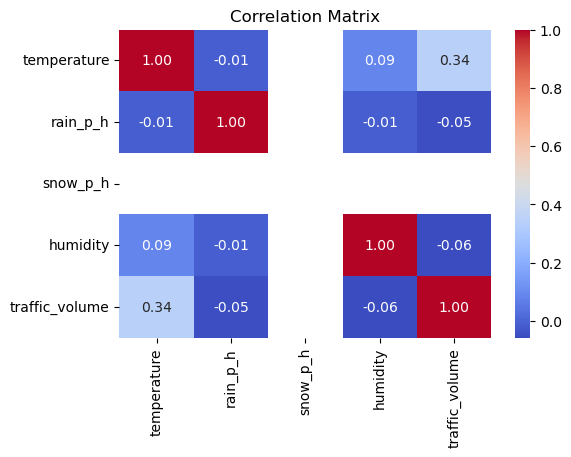

In [34]:
import seaborn as sns

# Compute correlation matrix
correlation_matrix = train.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select candidate variables
X = train[['temperature', 'rain_p_h', 'snow_p_h', 'humidity']]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 2) for i in range(len(X.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = X.corr().round(2)
print(f'Correlation:\n{corr}')

       feature    VIF          Interpretation
0  temperature  42.77  High Multicollinearity
1     rain_p_h   1.03   Not Multicollinearity
2     snow_p_h    NaN               Undefined
3     humidity  42.71  High Multicollinearity

Correlation:
             temperature  rain_p_h  snow_p_h  humidity
temperature         1.00     -0.01       NaN      0.09
rain_p_h           -0.01      1.00       NaN     -0.01
snow_p_h             NaN       NaN       NaN       NaN
humidity            0.09     -0.01       NaN      1.00


In [36]:
exog_data = train[['temperature']]         # Multiple column selection
endog_data = train['traffic_volume']       # Target variable selection

In [37]:
# Perform a full search over the same grid as the manual SARIMAX model
auto_model = pm.auto_arima(
    y=endog_data,               # The endogenous time series
    X=exog_data,                # The exogenous time series
    seasonal=True,              # Enable seasonal component
    m=24,                       # Seasonal period
    d=0,                        # Set differencing 
    D=1,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p from 0 to 3
    start_q=0, max_q=3,         # q from 0 to 3
    start_P=0, max_P=2,         # P from 0 to 2
    start_Q=0, max_Q=2,         # Q from 0 to 2
    stepwise=True,              # Use stepwise search
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors
    suppress_warnings=True,     # Suppress warnings
    information_criterion='aic' # Use AIC to evaluate models
)
# Print best model
#print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=32217.840, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=29847.166, Time=30.67 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=30506.349, Time=48.99 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=32215.981, Time=1.25 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=29924.333, Time=1.22 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=29736.669, Time=118.84 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=162.27 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=76.82 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=31961.315, Time=141.52 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=29422.575, Time=151.27 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=29494.688, Time=70.26 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=230.66 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=96.16 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=29414.902, Time=233.86 sec
 ARIMA(3,0,0

In [39]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                    exog=exog_data, 
                    order=(2, 0, 1), 
                    seasonal_order=(2, 1, 0, 24),
                    enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      traffic_volume   No. Observations:                 1907
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 24)   Log Likelihood              -14308.165
Date:                             Tue, 06 May 2025   AIC                          28630.330
Time:                                     08:28:50   BIC                          28668.926
Sample:                                          0   HQIC                         28644.564
                                            - 1907                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    30.9216      9.161      3.375      0.001      12.967      48.876
ar.L1           1.0508  

In [40]:
# Assuming 'results' is your fitted SARIMAX model
exo_1_coef = model_fit_M.params['temperature']         # Extract coefficient
exo_1_p = model_fit_M.pvalues['temperature']           # Extract p-value

print(f"Temperature coefficient: {exo_1_coef:.4f}")
print(f"Temperature p-value: {exo_1_p:.4f}")

Temperature coefficient: 30.9216
Temperature p-value: 0.0007


In [41]:
# Get the list of exogenous variable names (they appear first in the params/pvalues)
exo_vars = [name for name in model_fit_M.params.index if name not in ['sigma2'] and not name.startswith(('ar.', 'ma.', 'ar.S.', 'ma.S.'))]

# Extract the first exogenous variable's name
exo_1_name = exo_vars[0]

# Extract its p-value and coefficient
exo_1_coef = model_fit_M.params[exo_1_name]
exo_1_p = model_fit_M.pvalues[exo_1_name]

print(f"{exo_1_name} coefficient: {exo_1_coef:.4f}")
print(f"{exo_1_name} p-value: {exo_1_p:.4f}")

# Decision rule for statistical irrelevance
if abs(exo_1_coef) < 0.1 and exo_1_p > 0.05:
    print(f'{exo_1_name} is statistically IRRELEVANT in the model.\n')
else:
    print(f'{exo_1_name} is statistically RELEVANT in the model.\n')

temperature coefficient: 30.9216
temperature p-value: 0.0007
temperature is statistically RELEVANT in the model.



In [42]:
# Identify exogenous variables: exclude AR, MA, seasonal terms, and sigma2
exo_vars = [name for name in model_fit_M.params.index 
            if name not in ['sigma2'] and not name.startswith(('ar.', 'ma.', 'ar.S.', 'ma.S.'))]

# Loop over each exogenous variable and evaluate its statistical relevance
for var in exo_vars:
    coef = model_fit_M.params[var]
    p_val = model_fit_M.pvalues[var]
    
    print(f"{var} coefficient: {coef:.4f}")
    print(f"{var} p-value: {p_val:.4f}")
    
    if abs(coef) < 0.1 and p_val > 0.05:
        print(f"{var} is statistically IRRELEVANT in the model.\n")
    else:
        print(f"{var} is statistically RELEVANT in the model.\n")

temperature coefficient: 30.9216
temperature p-value: 0.0007
temperature is statistically RELEVANT in the model.



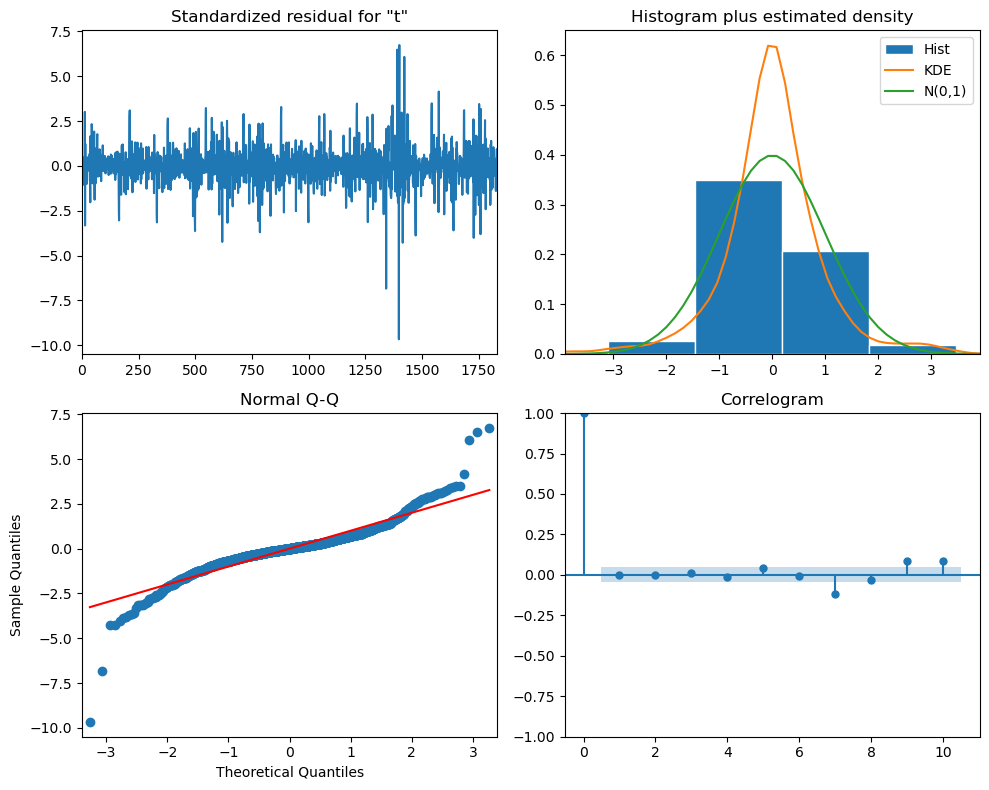

In [43]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [44]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,22.082519,2.611774e-06
2,45.072289,1.631837e-10
3,65.866104,3.273994e-14
4,79.182953,2.594628e-16
5,105.820630,3.128019e-21
6,117.178171,6.375424e-23
7,117.745938,2.256958e-22
8,122.514713,1.002371e-22
9,156.735794,3.537309e-29
10,193.121631,4.378633e-36


In [45]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.7680
Conclusion: No significant autocorrelation.


In [46]:
# Must match the structure of training exog
exog_test_M = test[['temperature']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=212, exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['traffic_volume']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,temperature,rain_p_h,snow_p_h,humidity,traffic_volume,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
date_time,,,,,,,,,,,,,
2015-09-20 13:00:00,293.77,0.00,0.0,63,4124,4102.720515,-21.279485,2936.755049,5268.685981,4121.383315,-2.616685,2957.200250,5285.566380
2015-09-20 14:00:00,294.58,0.00,0.0,62,4070,4395.888942,325.888942,2540.886919,6250.890966,4427.389340,357.389340,2576.047918,6278.730763
2015-09-20 15:00:00,294.54,0.00,0.0,64,4185,4568.961005,383.961005,2363.688202,6774.233808,4591.211332,406.211332,2391.003639,6791.419024
2015-09-20 16:00:00,294.45,0.00,0.0,61,4183,5080.525390,897.525390,2716.904287,7444.146493,5103.634153,920.634153,2745.315743,7461.952564
2015-09-20 17:00:00,292.86,0.25,0.0,62,4054,5141.018016,1087.018016,2711.845932,7570.190100,5142.551966,1088.551966,2718.315577,7566.788356


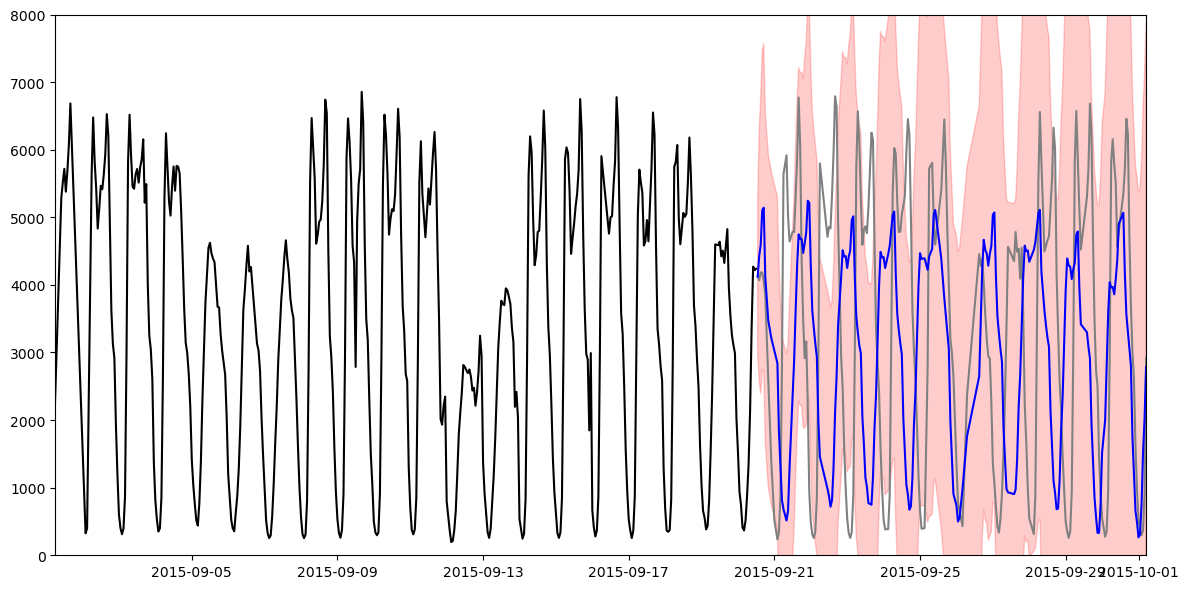

In [47]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['traffic_volume'], label='Train', color='black')                      
plt.plot(test.index, test['traffic_volume'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast M'], label='Forecasting', color='blue') 

# Formatting
ax.set_xlabel('Time', fontsize=12)  
ax.set_ylabel('Traffic Volume', fontsize=12)  
ax.set_title('Traffic Volume Over Time', fontsize=14)  
plt.xlim(pd.to_datetime('2015-09-01 06:00:00'), pd.to_datetime('2015-10-01 05:00:00'))
plt.ylim(0,8000)

# Show the plot
plt.tight_layout()
plt.show();

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast103
mae_s = mean_absolute_error(test['traffic_volume'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['traffic_volume'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['traffic_volume'], test['Forecast S']) * 100

# Metrics for ForecastM
mae_m = mean_absolute_error(test['traffic_volume'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['traffic_volume'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['traffic_volume'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    'MAPE': mape_m,
}

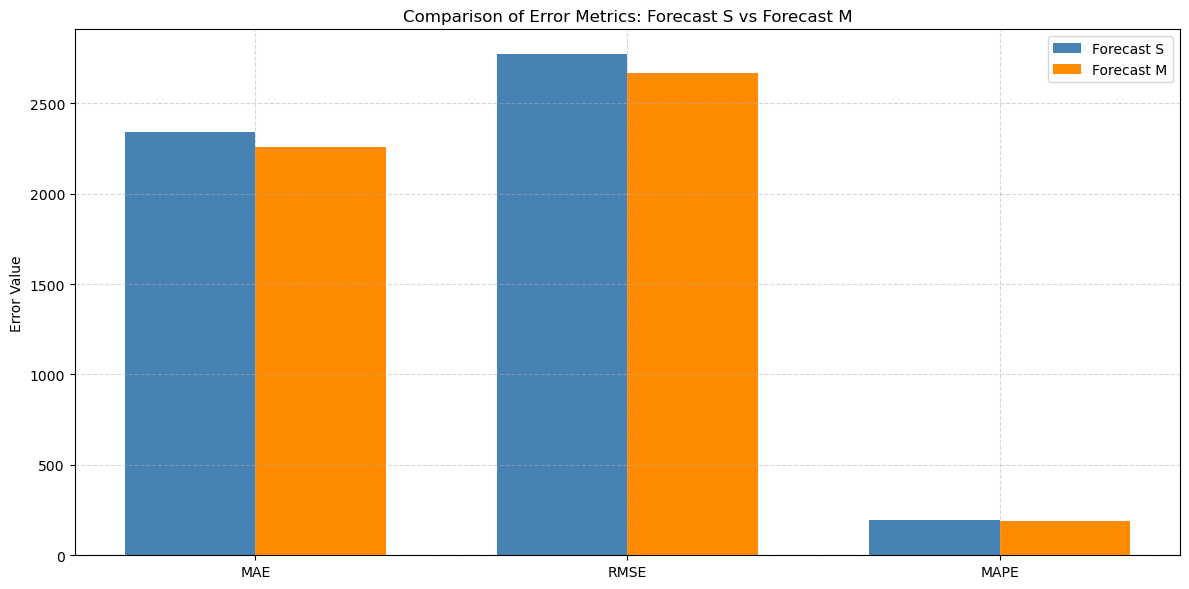

In [49]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [50]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,2338.35,2259.17
RMSE,2770.23,2664.76
MAPE,193.72,190.98


End.